In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

In [146]:
df_pwf16 = pd.read_csv('data/DF_Intercambios.csv')
df_pwf25 = pd.read_csv('data/DF_HVDC.csv').drop('Nome Elo', axis=1)
df_pwf16.columns = ['Nome Elo', 'Dia', 'Hora', 'P(MW)', 'Q(Mvar)']
df_pwf25.columns = ['Nome Elo', 'Dia', 'Hora', 'P(MW)', 'Q(Mvar)']

df_pwf = pd.concat([df_pwf16, df_pwf25], axis=0).reset_index().drop('index', axis=1)

In [147]:
df_pwf

,Nome Elo,Dia,Hora,P(MW),Q(Mvar)
0,EXP_NE,2,00-00,6706.2,-897.00
1,EXP_NE,2,00-30,6579.6,-847.80
2,EXP_NE,2,01-00,6434.8,-1042.30
3,EXP_NE,2,01-30,6294.9,-1114.90
4,EXP_NE,2,02-00,6198.2,-1064.40
...,...,...,...,...,...
13435,Elo_XINGU-SE,29,21-30,4549.0,2233.80
13436,Elo_XINGU-SE,29,22-00,4491.0,2210.07
13437,Elo_XINGU-SE,29,22-30,4054.0,2002.99
13438,Elo_XINGU-SE,29,23-00,3702.0,1765.79


In [191]:
df_pwf[df_pwf['Nome Elo'] == 'EXP_NE']['P(MW)'].min()

-127.69999999999996

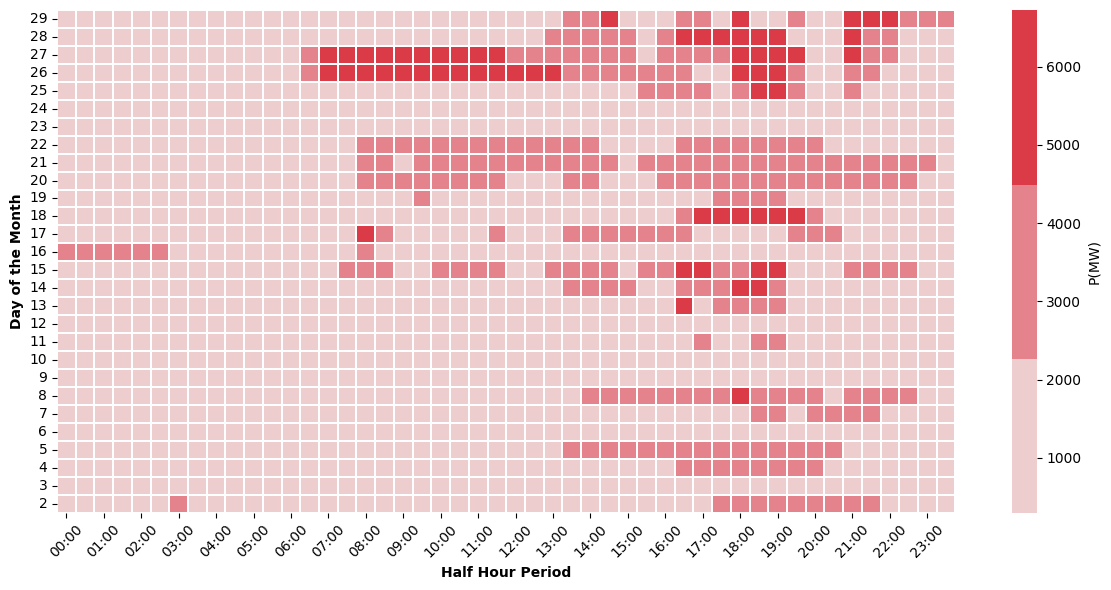

In [205]:
max_day = max(sorted(list(set(df_pwf['Dia']))))
min_day = min(sorted(list(set(df_pwf['Dia']))))
n_days = len(sorted(list(set(df_pwf['Dia']))))
half_hour_list = sorted(list(set(df_pwf['Hora'])))
n_half_hour = len(half_hour_list)
half_hour_periods = pd.date_range(start='2023-10-17', periods=n_half_hour, freq='30T').strftime('%H:%M')

elo_dataset = df_pwf[df_pwf['Nome Elo'] == 'Elo_XINGU-SE']

active_power = np.array(elo_dataset['P(MW)']).reshape(n_days, -1)
heatmap_data = pd.DataFrame(active_power[::-1], index=range(max_day, min_day-1, -1), columns=half_hour_periods) 

vmax = elo_dataset['P(MW)'].max()
vmin = elo_dataset['P(MW)'].min()

if vmin >= 0 or (vmin <= 0 and vmax <= 0):
    cmap = sns.diverging_palette(230, 10, as_cmap=False)
else:
    cmap = 'seismic'

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.heatmap(heatmap_data, cmap=cmap, center=0, 
            xticklabels=2, cbar_kws={'label': 'P(MW)'}, 
            linewidths=0.1, linecolor="white", mask=heatmap_data == 0.0)  
plt.xticks(rotation=45)

ax.set_xlabel('Half Hour Period', weight='bold')
ax.set_ylabel('Day of the Month', weight='bold')
# ax.set_title(fr'{frm}$\rightarrow${to}', weight='bold', fontsize=22, x=0.5, y=1.03)

plt.tight_layout()
plt.show()
# ['EXP_NE', 'Fluxo_NE-SE', 'Fluxo_N-S', 'Fluxo_SUL-SECO', 'Fluxo_NE-N', 'Fluxo_RSUL', 'Elo_FOZ-IBIUNA', 'Elo_PVEL-ARARQ', 'Elo_CPVBTB-PVEL', 'Elo_XINGU-SE']

In [ ]:
def flow_heatmap(dataset, col=None, frm=None, to=None, center=None):
    from matplotlib.colors import LinearSegmentedColormap

    n_days = len(sorted(list(set(dataset['Dia'])))) 
    half_hour_list = sorted(list(set(dataset['Hora'])))
    n_half_hour = len(half_hour_list)
    half_hour_periods = pd.date_range(start='2023-10-17', periods=n_half_hour, freq='30T').strftime('%H:%M')

    active_power = np.array(dataset[col]).reshape(n_days, -1)
    heatmap_data = pd.DataFrame(active_power[::-1], index=range(n_days, 0, -1), columns=half_hour_periods)    

    vmax = dataset[col].max()
    vmin = dataset[col].min()
    
    colors = [[0, 'blue'],
          [- vmin / (vmax - vmin), 'white'],
          [(1 - vmin)/ (vmax - vmin), 'white'],
          [1, 'red']]
       
    if vmin >= 0 or (vmin <= 0 and vmax <= 0):
      cmap = sns.diverging_palette(230, 10, as_cmap=False)
    else:
      cmap = LinearSegmentedColormap.from_list('', colors) 
       

    n = 2
    
    plt.figure(figsize=(12, 6))
    
    sns.heatmap(heatmap_data, cmap=cmap, center=center, 
                xticklabels=n, cbar_kws={'label': f'{col}'}, 
                linewidths=0.1, linecolor="white", mask=heatmap_data == 0.0)     

    plt.xticks(rotation=45)

    plt.xlabel('Half Hour Period', weight='bold')
    plt.ylabel('Day of the Month', weight='bold')
    plt.title(fr'{frm}$\rightarrow${to}', weight='bold', fontsize=22, x=0.5, y=1.03)

    plt.show()

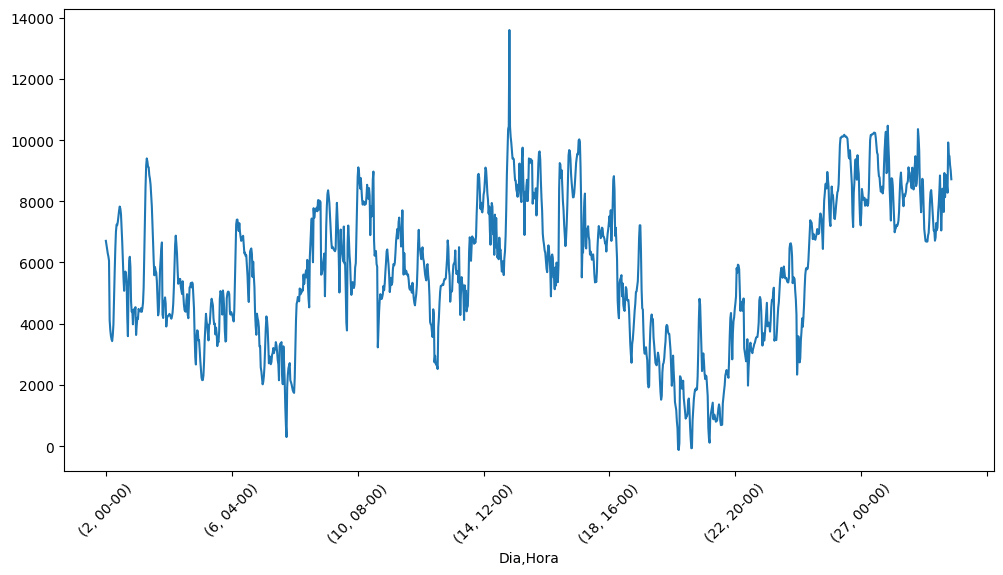

In [3]:
fig, ax = plt.subplots(figsize=(12, 6))
df_pwf[df_pwf['Nome Elo'] == 'EXP_NE']['P(MW)'].plot(ax=ax)
ax.tick_params(axis='x', labelrotation=45)
# ax.

In [4]:
# ['EXP_NE', 'Fluxo_NE-SE', 'Fluxo_N-S', 'Fluxo_SUL-SECO', 'Fluxo_NE-N', 'Fluxo_RSUL', 'Elo_FOZ-IBIUNA', 'Elo_PVEL-ARARQ', 'Elo_CPVBTB-PVEL', 'Elo_XINGU-SE']

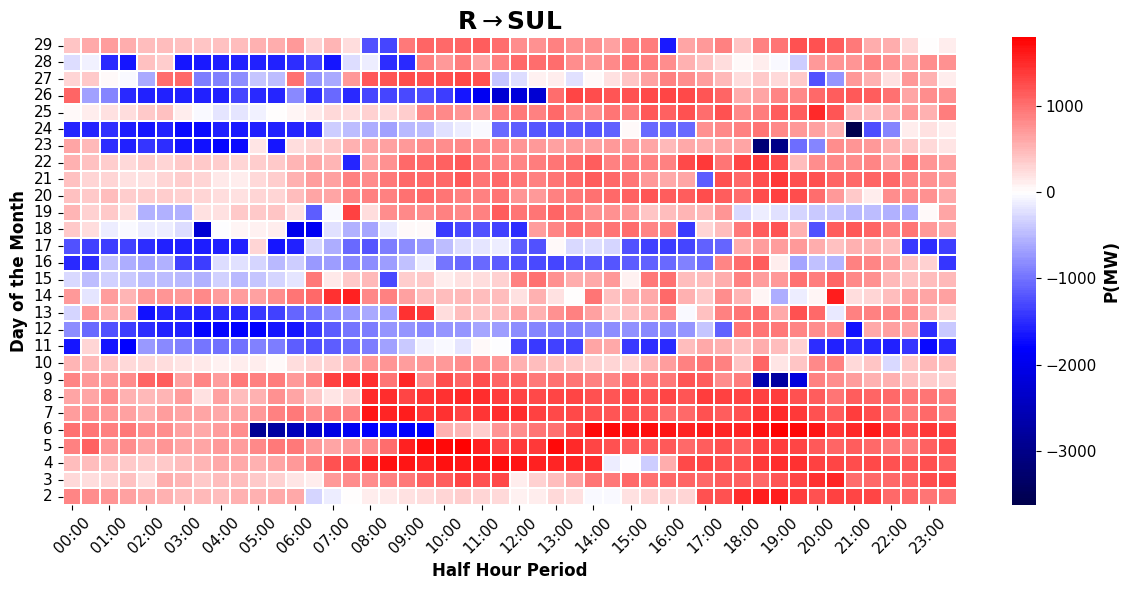

In [221]:
class CreatePlots:
    def __init__(self):
        pass

    def persistency_curve(self, dataset, nome_elo=None, col=None, 
                          frm=None, to=None, path=None, ax_fontsize=None):
        
        dataset = pd.DataFrame(dataset[dataset['Nome Elo'] == nome_elo][col])

        fig, ax = plt.subplots(figsize=(12, 6))

        x = np.sort(np.array(dataset[col]))
        N = len(x)
        y = np.linspace(1, N, N)

        import_values = len(dataset[dataset[col] < 0])
        export_values = len(dataset[dataset[col] > 0])
        
        total_import = round((import_values / N) * 100, 2)
        total_export = round((export_values / N) * 100, 2)


        plt.plot(y[:import_values], x[:import_values], lw=3, c='red', label=f'Import: {total_import}% (-)')
        plt.plot(y[import_values:export_values], x[import_values:export_values], lw=3, c='blue', label=f'Export: {total_export}% (+)')
        ax.set_ylabel(f'{col}', weight='bold', fontsize=14) 
        ax.set_title(fr'Persistency Curve {frm}$\rightarrow${to}', weight='bold', fontsize=20)
        ax.set_xlabel('# Operation Points', weight='bold', fontsize=14)
 
        ax.axhline(y=0, color='k', ls='--', alpha=0.3)
        ax.tick_params(color='black', labelcolor='black')
        ax.grid(visible=True, alpha=0.3)

        ax.tick_params(axis='both', which='major', labelsize=ax_fontsize)
        ax.tick_params(axis='both', which='minor', labelsize=ax_fontsize)

        ax.legend(bbox_to_anchor=(0.01, 1.00), fontsize=13, 
          loc='upper left', fancybox=True, shadow=True)
        
        plt.tight_layout()

        if path != None:
            plt.savefig(f'{path}/PC_{nome_elo}')

        plt.show()

    def box_plots(self, dataset, col=None, path=None, ax_fontsize=None):
        import warnings
        warnings.filterwarnings('ignore')

        fig, ax = plt.subplots(1, 1, figsize=(15, 6))
        ax = sns.boxplot(
            data=dataset, 
            x="Nome Elo", 
            y=col, 
            notch=True, 
            showcaps=False,
            flierprops={"marker": "x"}, 
            hue=df_pwf['Nome Elo'],
            palette=sns.color_palette("hls", 8)
        )

        ax.set_ylabel(f'{col}', weight='bold', fontsize=13)
        ax.set_xlabel('Nome Elo', weight='bold', fontsize=13)
        ax.grid(True, alpha=0.3)
        ax.set_xticklabels(dataset['Nome Elo'].unique(), rotation=30)

        ax.tick_params(axis='both', which='major', labelsize=ax_fontsize)
        ax.tick_params(axis='both', which='minor', labelsize=ax_fontsize)

        plt.tight_layout()

        if path != None:
            plt.savefig(f'{path}/BoxPlot_{col}')

        plt.show()

    def violin_plots(self, dataset, col=None, path=None, ax_fontsize=None):
        import warnings
        warnings.filterwarnings('ignore')

        fig, ax = plt.subplots(1, 1, figsize=(15, 6))
        ax = sns.violinplot(
            data=dataset, 
            x="Nome Elo", 
            y=col, 
            hue=df_pwf['Nome Elo'],
            palette=sns.color_palette("hls", 8)
        )

        ax.set_ylabel(f'{col}', weight='bold', fontsize=13)
        ax.set_xlabel('Nome Elo', weight='bold', fontsize=13)
        ax.grid(True, alpha=0.3)
        ax.set_xticklabels(dataset['Nome Elo'].unique(), rotation=30)

        ax.tick_params(axis='both', which='major', labelsize=ax_fontsize)
        ax.tick_params(axis='both', which='minor', labelsize=ax_fontsize)

        plt.tight_layout()

        if path != None:
            plt.savefig(f'{path}/ViolinPlot_{col}')

        plt.show()
    
    def create_heatmap(self, dataset, nome_elo, col=None, frm=None, to=None, path=None, ax_fontsize=None):
        max_day = max(sorted(list(set(dataset['Dia']))))
        min_day = min(sorted(list(set(dataset['Dia']))))
        n_days = len(sorted(list(set(dataset['Dia']))))
        half_hour_list = sorted(list(set(dataset['Hora'])))
        n_half_hour = len(half_hour_list)
        half_hour_periods = pd.date_range(start='2023-10-17', periods=n_half_hour, freq='30T').strftime('%H:%M')

        elo_dataset = dataset[dataset['Nome Elo'] == nome_elo]

        active_power = np.array(elo_dataset[col]).reshape(n_days, -1)
        heatmap_data = pd.DataFrame(active_power[::-1], index=range(max_day, min_day-1, -1), columns=half_hour_periods) 

        vmax = elo_dataset[col].max()
        vmin = elo_dataset[col].min()

        if vmin >= 0 or (vmin <= 0 and vmax <= 0):
            cmap = sns.diverging_palette(230, 10, as_cmap=False)
        else:
            cmap = 'seismic'

        fig, ax = plt.subplots(1, 1, figsize=(12, 6))

        ax = sns.heatmap(heatmap_data, cmap=cmap, center=0, 
                    xticklabels=2, cbar_kws={'label': col}, 
                    linewidths=0.1, linecolor="white", mask=heatmap_data == 0.0)  
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=11)
        cbar.ax.set_ylabel(col, size=12, weight='bold')

        plt.xticks(rotation=45)

        ax.set_xlabel('Half Hour Period', weight='bold', fontsize=12)
        ax.set_ylabel('Day of the Month', weight='bold', fontsize=12)
        ax.set_title(fr'{frm}$\rightarrow${to}', weight='bold', fontsize=18)

        ax.tick_params(axis='both', which='major', labelsize=ax_fontsize)
        ax.tick_params(axis='both', which='minor', labelsize=ax_fontsize)

        plt.tight_layout()
        if path != None:
            plt.savefig(f'{path}/Heatmap_{frm}_{to}')
        plt.show()


    def create_contourplot(self):
        pass

    def flow_profiles(self):
        pass

    

path = 'results'
plotter = CreatePlots()
# plotter.persistency_curve(dataset=df_pwf, 
#                           nome_elo='Fluxo_RSUL', 
#                           col='P(MW)', 
#                           frm='R', 
#                           to='SUL', 
#                           path=path, 
#                           ax_fontsize=13)
# plotter.box_plots(dataset=df_pwf, 
#                   col='P(MW)', 
#                   path=path, 
#                   ax_fontsize=11)
# plotter.violin_plots(dataset=df_pwf, 
#                   col='P(MW)', 
#                   path=path, 
#                   ax_fontsize=11)
plotter.create_heatmap(dataset=df_pwf, 
                        nome_elo='Fluxo_RSUL', 
                        col='P(MW)', 
                        frm='R', 
                        to='SUL', 
                        path=path, 
                        ax_fontsize=11)